# BIP Framework training example 

In [1]:
using Pkg
Pkg.activate("..")
using BIPs

  Activating project at `/z1-josemm/josemm/MyDocs/personal_BIP/BIPs.jl`


In [2]:
using Statistics
using Pkg.Artifacts

Lets begin by bringing in the dataset. It contains tree splits:
* **train**: the training set with 1M jets
* **validation**: the validation set with 400k jets

And of course later we will use the **test** set with other 400k jets to report the results


In [3]:
dataset_path = "../../../DataLake/raw"
# dataset_path = "/Users/ortner/datasets/toptagging"

train_data_path = dataset_path*"/train.h5"
val_data_path = dataset_path*"/val.h5"

"../../../DataLake/raw/val.h5"

### Reading the data

In order to read the datasets, we call the `read_dataset` function:
to read the TopQuark format

In [4]:
train_jets, train_labels = BIPs.read_data("TQ", train_data_path)
train_labels = [reinterpret(Bool, b == 1.0) for b in train_labels]
print("Number of entries in the training data: ", length(train_jets))

Number of entries in the training data: 1210997

In [5]:
val_jets, val_labels = BIPs.read_data("TQ", val_data_path)
val_labels = [reinterpret(Bool, b == 1.0) for b in val_labels]
print("Number of entries in the validation data: ", length(val_jets))

Number of entries in the validation data: 402999

Lets examine how one of the jets looks like, each one of the entries is one detected particle's four momentum $(E, p_x, p_y, p_z)$.

However,in order to compute the embeddings, it is necesary to convert the jets to a format that can be used by the framework. The function `data2hyp` allows to convert each detected four momentum to the jet basis, a.k.a $(\tilde p_T, \cos(\theta), \sin(\theta), \tilde y, E_T)$

In [6]:
train_transf_jets = data2basis(train_jets; basis="hyp")
val_transf_jets = data2basis(val_jets; basis="hyp")
println("Transformed jets")

Transformed jets


### The embeddings

Once the jets are converted to the jet basis, it is moment to embed the model using the *Invariant Polynomials*. 

The function `build_ip` allocates efficiently the sparse basis, while the `bip_data` computes the invariant representation of each one of the jets.

In [8]:
f_bip, specs, a_basis = build_ip(order=3, levels=6)
    
function bip_data(dataset_jets)
    storage = zeros(length(dataset_jets), length(specs))
    for i = 1:length(dataset_jets)
        storage[i, :] = f_bip(dataset_jets[i])
    end
    storage[:, 2:end]
end

bip_data (generic function with 1 method)

In [8]:
specs

3×312 Matrix{Int64}:
 0  1  6  19  44  81  126  1  6  19  …  19  17  16  17  16  15  19  19  19
 0  0  0   0   0   0    0  1  1   1     11  17  16  15  15  15  18  17  19
 0  0  0   0   0   0    0  0  0   0     10  10  11  12  13  14  15  16  19

In [47]:
train_embedded_jets = bip_data(train_transf_jets)
println("Embedded train jets correclty")
val_embedded_jets = bip_data(val_transf_jets)
println("Embedded test jets correclty")

Embedded train jets correclty


Embedded test jets correclty


In [48]:
length(specs)

312

### Training a classifier model

The embeddings are now created for the dataset. From this point on, the classification itself is absolutelly versatile. For this specific example we will use the out-of-the box classifier `sklearn.linear_model.HistGradientBoostingClassifier` that bines the data and then applies a grandient boosted trees algorithm. 

Now, lets fit a simple model to the data.


In [49]:
using PyCall
@pyimport sklearn.ensemble as sk_ensemble

In [50]:
GCT = sk_ensemble.HistGradientBoostingClassifier(verbose=false, max_iter=3000, l2_regularization=0.02, learning_rate=0.02, max_depth = 4).fit(train_embedded_jets, train_labels)

PyObject HistGradientBoostingClassifier(l2_regularization=0.02, learning_rate=0.02,
                               max_depth=4, max_iter=3000, verbose=False)

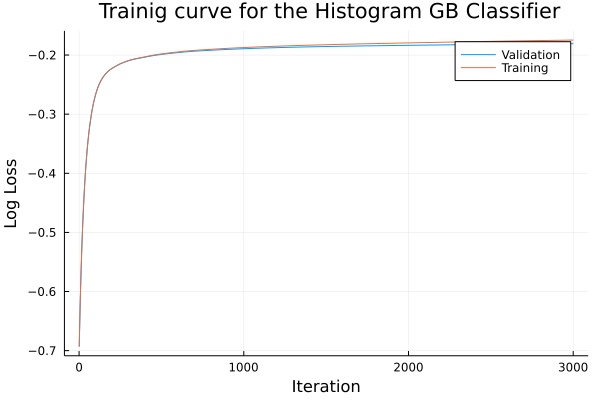

In [51]:
using Plots
Plots.plot(GCT[:validation_score_], label="Validation", xlabel="Iteration", ylabel="Log Loss")
Plots.plot!(GCT[:train_score_], label="Training", title=" Trainig curve for the Histogram GB Classifier")

# Lest test how we do performance

Now that we understanad the framework, lets see how our model performs on the test set.

In [10]:
test_data_path = "../../../DataLake/raw/test.h5"

"../../../DataLake/raw/test.h5"

In [13]:
test_jets, test_labels = BIPs.read_data("TQ", test_data_path)
test_labels = [reinterpret(Bool, b == 1.0) for b in test_labels]
test_transf_jets = data2basis(test_jets; basis="hyp")
test_embedded_jets = bip_data(test_transf_jets)
print("Embedded test jets correclty")

Embedded test jets correclty

In [54]:
test_preds = GCT.score(test_embedded_jets, test_labels)

0.9267296539330737

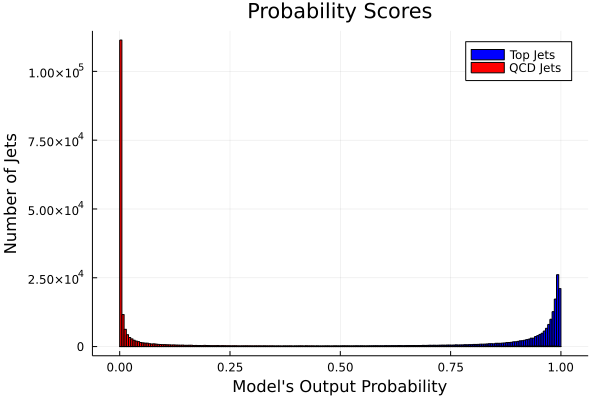

In [55]:
test_probas = GCT.predict_proba(test_embedded_jets)
bkg_index = [label==false for label in test_labels]
Plots.histogram(test_probas[:, 2][test_labels], color="Blue", label="Top Jets", xlabel="Model's Output Probability", ylabel="Number of Jets")
Plots.histogram!(test_probas[:, 2][bkg_index], color="Red", label="QCD Jets", title="Probability Scores")

In [6]:
using DelimitedFiles

In [57]:
#writedlm( "../foo/h_bin_test_probas.csv",  test_probas, ',')


In [7]:
writedlm( "../foo/normal_trailabels.csv",  train_labels, ',')
writedlm( "../foo/normal_val_labels.csv",  val_labels, ',')


In [15]:
writedlm( "../foo/normal_test_basis.csv",  test_embedded_jets, ',')

In [10]:
specs[:,107]

3-element Vector{Int64}:
 6
 6
 1

In [20]:
a_basis.spec[[6,6,1]]

3-element Vector{BIPs.BiPolynomials.Modules.ASpec}:
 BIPs.BiPolynomials.Modules.ASpec(1, 0, 0)
 BIPs.BiPolynomials.Modules.ASpec(1, 0, 0)
 BIPs.BiPolynomials.Modules.ASpec(0, 0, 0)